### Introduction

In this task, we are looking at customer churn data from the Telco industry. This data containes information such as customer services (multiple lines, internet service, online security and backup, streaming, ect.), account information (charges, contract, payment menthod, billing, etc.) and personal information (gender, age, whether they have dependents, etc.). We will be going into more detail regarding some of these and their relationship to churn (when customers decide to end their subscriptions).

The goal will be to use this historical customer data to train a logistic regression model as well as a random forest model and assess which of these can better forecast customer churn. The industry can then use this predictive capability to implement effective retention techniques.

Source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
# Load dataset
try:
    telco_df = pd.read_csv("Telco-Customer-Churn.csv")
except FileNotFoundError:
    print(
        "The file 'Telco-Customer-Churn.csv' does not exist "
        "or is in the wrong folder."
    )

Now that the data is loaded, let's start inspection on what we have.

### Data inspection

First, let's look at the first 10 rows.

In [3]:
# Display first 10 rows
telco_df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


We have 21 columns in this dataset. Since we cannot see each of them right away, let's take a look at only the column names.

In [4]:
# Look at column names
print("Columns of dataset:")
telco_df.columns

Columns of dataset:


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Next, we will look at the data types of each column.

In [5]:
# Get overview of each column's datatype
print("Overview of dataset:")
telco_df.info()

Overview of dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  704

After looking at each column's datatype, it appears that TotalCharges is an object datatype, but should be a numeric datatype such as float64 like MonthlyCharges. The only other numeric columns are SeniorCitizen and Tenure. Since we now have an overview, we can start to preprocess the data.

### Data Preprocessing

As mentioned, TotalCharges should be a numerical data type column and not a object column. Let's change that.

In [6]:
# Convert TotalCharges column to numeric data type
telco_df['TotalCharges'] = (
    pd.to_numeric(telco_df['TotalCharges'], errors='coerce')
)

Since the column was an object data type column, entries such as empty spaces or '?' are also considered valid entries. The "errors='coerce'" will help change any invalid entries into NaN which will be considerd as a missing value. Following this, let's look for duplicates and what could be missing.

In [7]:
# Look at shape of dataframe
print("Shape of dataframe:")
telco_df.shape

Shape of dataframe:


(7043, 21)

Now let's see if there are any duplicates.

In [8]:
# Drop duplicates from dataframe
telco_df.drop_duplicates()

# Print shape after dropping duplicates
print("Shape of dataframe after dropping duplicates:")
telco_df.shape

Shape of dataframe after dropping duplicates:


(7043, 21)

As seen above, the shape stayed the same meaning none of the entries were duplicates. Now let's look at missing values.

In [9]:
# Look at count of missing values
missing_count = telco_df.isnull().sum()
print("Overview of what it missing:")
missing_count

Overview of what it missing:


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Here we can see that there were some entries in the TotalCharges column that is considdered missing values. Since it is only 11 records out of 7043 (as indicated by our dataframe shape), we can simply remove these rows with missing values.

In [10]:
# Remove missing values from dataset
telco_df = telco_df.dropna()

# Look at count of missing values again to confirm they are removed
missing_count_after_drop = telco_df.isnull().sum()
print("Count of missing values after removal:")
missing_count_after_drop

Count of missing values after removal:


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Now that missing values have been taken care of, let's take a further look at the columns. The customerID column does not look particularly useful and therefore can be dropped.

In [11]:
# Drop CustomerID colum
telco_df = telco_df.drop('customerID', axis=1)

Let's take another look at our data after all these changes were made.

In [12]:
# Look at top 15 rows
telco_df.head(15)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


Next, we will convert 'Churn' (our target variable) into binary numeric values which will make it easier for machine learning models to interpret.

In [13]:
# Convert Churn into binary numeric values
telco_df['Churn'] = telco_df['Churn'].map({'Yes': 1, 'No': 0})

# Confirm that Churn was converted
telco_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


As seen above, Churn is now in binary numeric values where 1 indicates a Yes and 0 indicates a No. Before creating dummy variables out of the rest of the categorical columns, let's first look at some of the categorical columns to see what their unique values are and to make sure there are no spelling mistakes or words that could mean the same thing. Some (not all) of these columns are gender, MultipleLines, InternetService, OnlineSecurity, StreamingTV, Contract and PaymentMethod.

In [14]:
# Make a list of the columns to loop through
columns = [
    'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'StreamingTV', 'Contract', 'PaymentMethod'
]

# Loop through list of columns and print unique values for each
for col in columns:
    print(f"Unique values for {col} :\n", telco_df[col].unique(), "\n")

Unique values for gender :
 ['Female' 'Male'] 

Unique values for MultipleLines :
 ['No phone service' 'No' 'Yes'] 

Unique values for InternetService :
 ['DSL' 'Fiber optic' 'No'] 

Unique values for OnlineSecurity :
 ['No' 'Yes' 'No internet service'] 

Unique values for StreamingTV :
 ['No' 'Yes' 'No internet service'] 

Unique values for Contract :
 ['Month-to-month' 'One year' 'Two year'] 

Unique values for PaymentMethod :
 ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 



There does not seem to be any smelling mistakes or words that could mean the same thing in the columns above. We can assume that this is also true for the rest of the categorical columns. Now we can move on to converting all categorical columns into dummy variables using one-hot coding. We will also be dropping every first column of the new dummy columns to avoid the dummy variable trap where one variable can be predicted by the other causing multicollinearity issues which is not ideal (source 1). This will also be saved to a new dataframe as to avoid losing or modifying the original data.

1. Source:
   https://blog.roundtableml.com/quickie-avoid-the-dummy-trap-c0664d1524dc

In [15]:
# Convert categorical into dummy variables for modeling
telecom_cust_dummies = pd.get_dummies(telco_df, drop_first=True, dtype=int)

# Look at first few rows of resulting dataframe
telecom_cust_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,1889.50,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42.30,1840.75,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,2,70.70,151.65,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


Now that everything is in numerical format, we can start analysing our data.

### Data Visualisation

To start off, let's look at the correlation between the target variable (churn) and the rest of the features. Since the first column of every new dummy column in telecom_cust_dummies were dropped to avoid the dummy variable trap, this means that some information that could be necessary for correlation was also dropped. For this correlation, we will create another dataframe with the dummy variables without dropping the first created column.

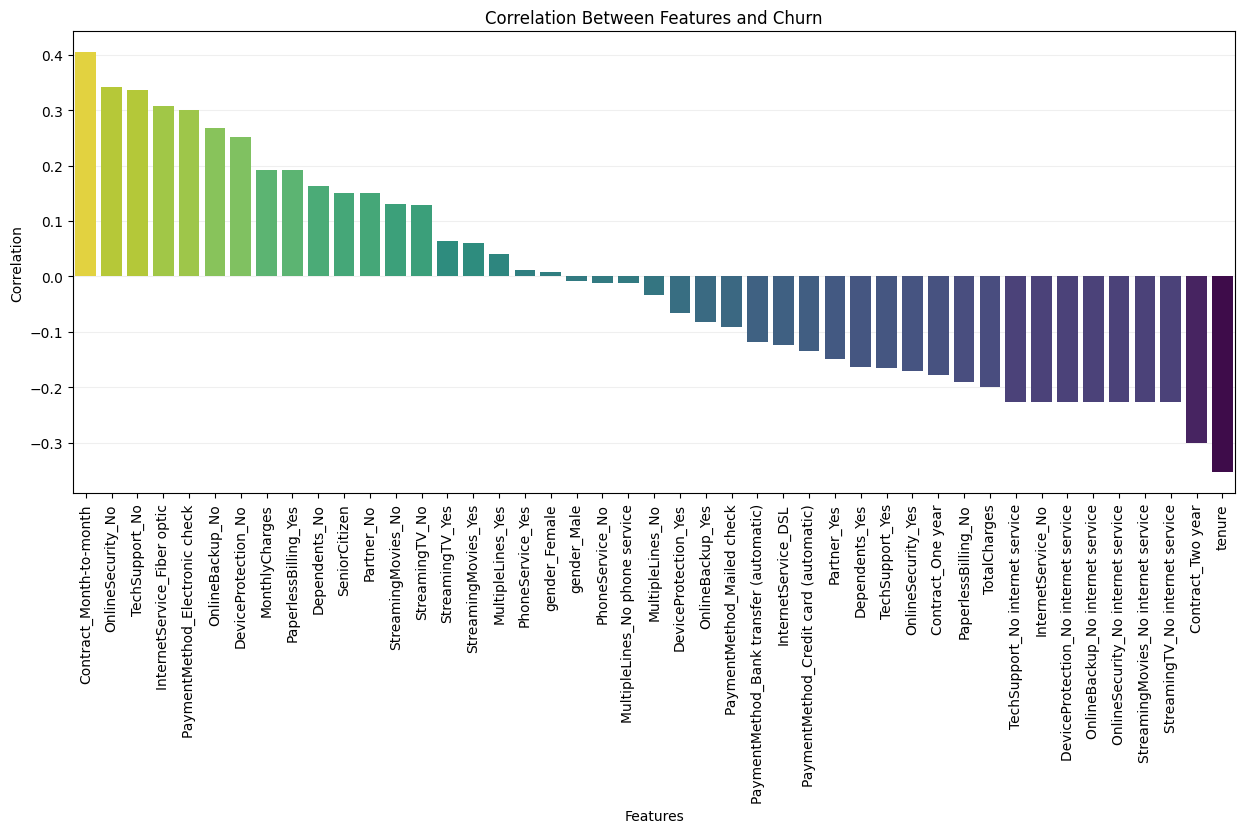

In [16]:
# Get dummy dataframe without dropping first column
telco_corr_df = pd.get_dummies(telco_df, drop_first=False, dtype=int)

# Get correlation matrix
telco_corr_mat = telco_corr_df.corr()

# Get the correlations in regards with churn
churn_corr = (
    telco_corr_mat['Churn']
    .sort_values(ascending=False)
    .reset_index()
)
churn_corr.columns = ['Features', 'Correlation']  # Rename columns

# Plot matrix
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(
    data=churn_corr[1:],  # Start from second column to exclude Churn itself
    x='Features',
    y='Correlation',
    hue='Correlation',
    palette='viridis',
    legend=False
)

# Labels
plt.title("Correlation Between Features and Churn")
plt.xlabel("Features")
plt.xticks(rotation=90)

# Set grid behind graph
ax.set_axisbelow(True)
ax.grid(axis='y', alpha=0.2)

Features that are strongly correlation to customers that churn, in other words, features that increase the probability of a customer to churn, are when it is a month-to-month contract, when the customer does not have online security or tech support, when the internet service is fiber optic, when the payment method is via electronic check. These all have a correlation of 0.3 or above. 

Features that are negatively correlated with churn are features such as tenure and when it is a two-year contract. These features have a correlation of -0.3 or below. 
This gives the impression that customers who have been with the company for longer periods of time and who have long-term contracts are less likely to end their subscriptions.

Interestingly, monthly charges have a positive correlation with churn, however total charges have a negative relationship with churn. Perhaps these are bundle deals for long term subscriptions that could be less expensive than month-to-month fees leading to month-to-month contracts having a higher probability of churn.

As tenure is one of the features that are strongly correlation to the customers who do not end their subscriptions (customers who do not churn), let's have a look at tenure next.

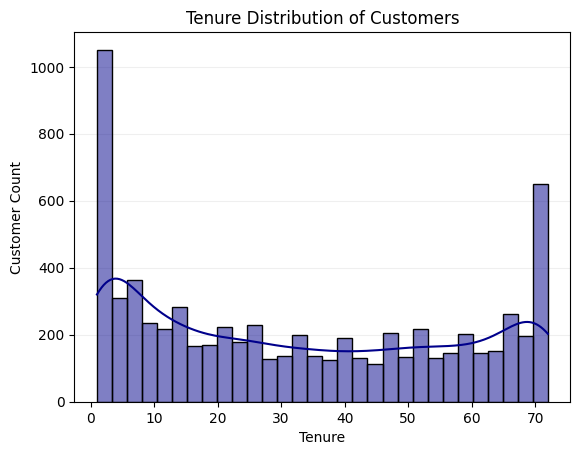

In [17]:
# Distribution of tenure among customers
fig, ax = plt.subplots()
sns.histplot(
    data=telecom_cust_dummies['tenure'],
    legend=False,
    kde=True,
    bins=30,
    color='darkblue'
)

# Labels
plt.title("Tenure Distribution of Customers")
plt.xlabel("Tenure")
plt.ylabel("Customer Count")

# Set grid below graph
ax.set_axisbelow(True)
ax.grid(axis='y', alpha=0.2)

From the above, we can see that the majority of customers are those that have been with the company only for about a month. These are the new subscribers of which some would probably churn and should be the focus of customer retention techniques. After the first month, there is a decline in customer count which suggest that the majority of customers churn. The customer count flattens out after that which indicates a stable steady customer count. There is another spike again where many of the customers are those that have been with the company about 72 months. These are likely the customers who have 2-year contracts.

Next, let's take a look at some customer demographics in relation with churn. These are features such as gender, age, number of dependents and partners.

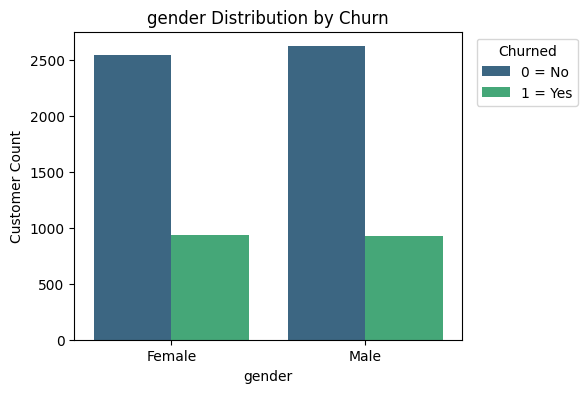

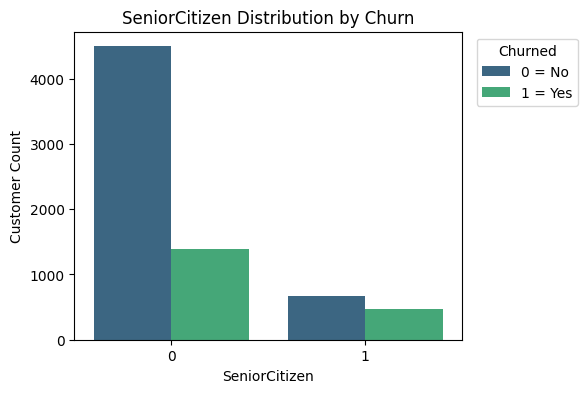

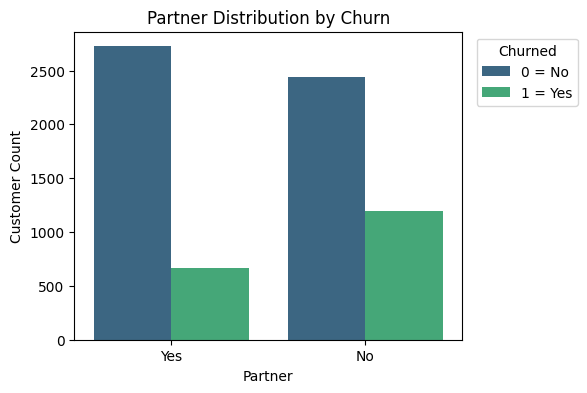

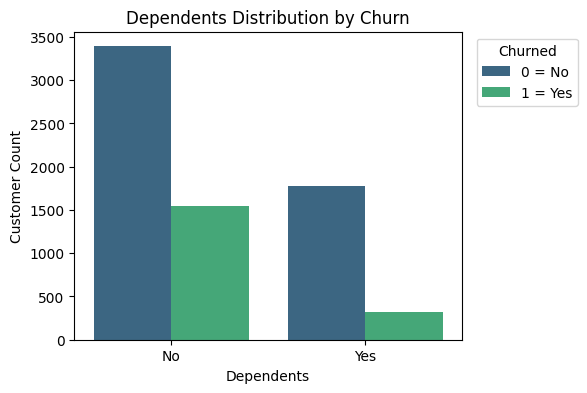

In [18]:
# Get demographics columns
demographics = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# Plot the demographics columns
for col in demographics:
    plt.figure(figsize=(5, 4))
    sns.countplot(
        data=telco_df,
        x=telco_df[col],
        hue=telco_df['Churn'],
        palette='viridis',
    )

    # Labels
    plt.title(f"{col} Distribution by Churn")
    plt.ylabel("Customer Count")
    plt.legend(
        title='Churned',
        labels=['0 = No', '1 = Yes'],
        loc='upper left',
        bbox_to_anchor=(1.02, 1)
    )

Findings from demographic distributions:

There is almost exactly the same number of males as there are females. For both genders, the majority did not churn (approximately 2500) while about 900 did churn. Since the numbers for both male and female are so similar, we can see why gender was not strongly correlated to churn in either the negative nor positive way, but that it was rather neutral in the middle and we can conclude form this that gender is not a strong predictor of customer churn.

Most of the customers are young and among them, approximately 1400 churned while more than 4000 did not churn. The minority of customers are senior citizens.

Customers who do not have partners or dependents are more likely to churn. 

Now, let's look at the relationship between monthly charges and total charges.

Text(0, 0.5, 'Total Charges')

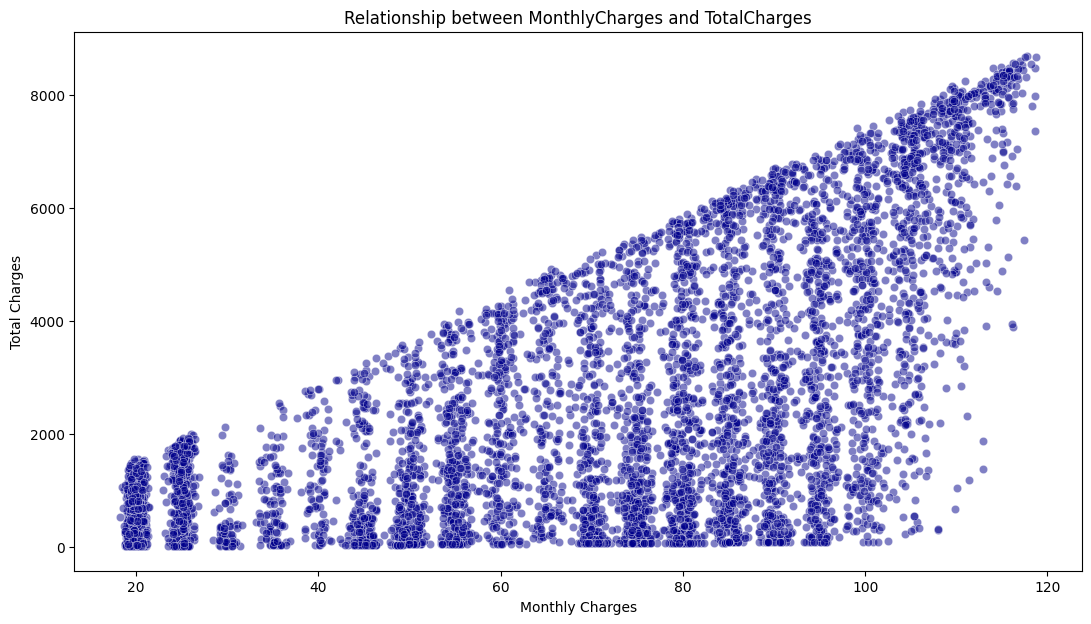

In [19]:
# MonthlyCharges vs TotalCharges
plt.figure(figsize=(13, 7))
sns.scatterplot(
    data=telecom_cust_dummies,
    x='MonthlyCharges',
    y='TotalCharges',
    alpha=0.5,
    color='darkblue'
)
plt.title("Relationship between MonthlyCharges and TotalCharges")
plt.xlabel("Monthly Charges")
plt.ylabel("Total Charges")


From this we can see that there is a clear upward (positive) trend between the monthly and total charges. As the monthly charges increase, so does the total charges. There are also some vertical clusters visible which are some monthly charges that are the same for many customers.  The densest clusters appear at the lowest rate (left bottom corner). This could possibly be a start-up rate for new comes. On the other hand, the clusters appearing in the upper right corner are possibly those that have been with the company for long and are high paying customers. The reason for the shape of the graph is due to customers with high monthly charges but low total charges. For some monthly charges, the total charges can vary widely depending on the period of time the customer has been with the company as well as possible package deals they may have agreed to with the company. The reason for the sparseness of datapoints in the lower right corner is due to no customer having very high monthly charges and along with that low total charges. In other words, customers with very high monthly charges all have high total charges. 

Next, we will look the tenure for churned and non-churned customers.

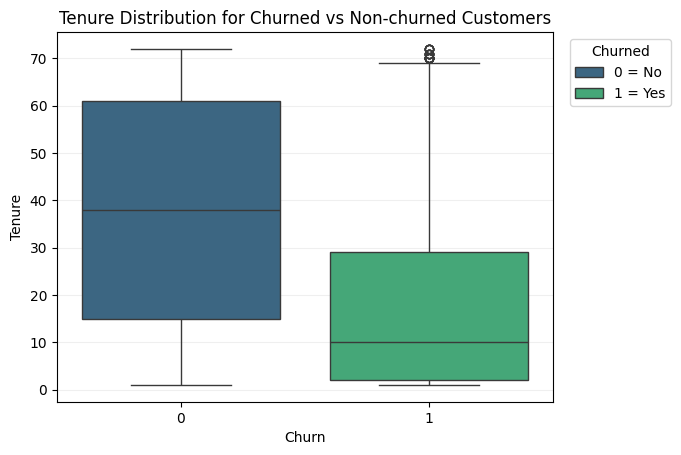

In [20]:
# Tenure distribution for churn and non-churned customers
fig, ax = plt.subplots()
sns.boxplot(
    data=telecom_cust_dummies,
    x='Churn',
    y='tenure',
    hue='Churn',
    palette='viridis'
)

# Labels
plt.title("Tenure Distribution for Churned vs Non-churned Customers")
plt.xlabel("Churn")
plt.ylabel("Tenure")
plt.legend(
    title='Churned',
    labels=['0 = No', '1 = Yes'],
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)

# Set grid behind graph
ax.set_axisbelow(True)
ax.grid(axis='y', alpha=0.2)

It is clear that customers that have not churned have been with the company for longer as indicated by a mean of approximately 38 in comparison to a mean of 10 for those who have churned. There are some outliers for those who churned where they have been with the company for long but decided to end their subscription. Most of the customers who churn do so between 1 and 30 months. Those who did not churn have the widest spread and the boxplot is also nearly symmetrical. Does this spread pattern mean that there are more customers who have not churned than customers who did? 

Let’s take a look at the customer churn count.

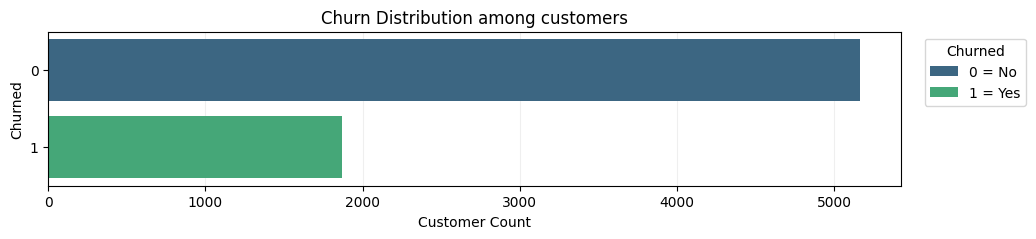

In [21]:
# Churn distribution among customers
fig, ax = plt.subplots(figsize=(11, 2))
sns.countplot(
    data=telecom_cust_dummies,
    y='Churn',
    hue='Churn',
    palette='viridis'
)

# Labels
plt.title("Churn Distribution among customers")
plt.ylabel("Churned")
plt.xlabel("Customer Count")
plt.legend(
    title='Churned',
    labels=['0 = No', '1 = Yes'],
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)

# Set grid behind graph
ax.set_axisbelow(True)
ax.grid(axis='x', alpha=0.2)

This confirms that there are indeed more customers who have not churned (more than 5000) in comparison to those who have (just below 2000).

Next, let's look at some other distributions in relation to churn. As mentioned in the introduction, this dataset contains customer information about the services to each customer. These services are: phone service, multiple lines, internet services, online security and backup, device protection, tech support and streaming services.

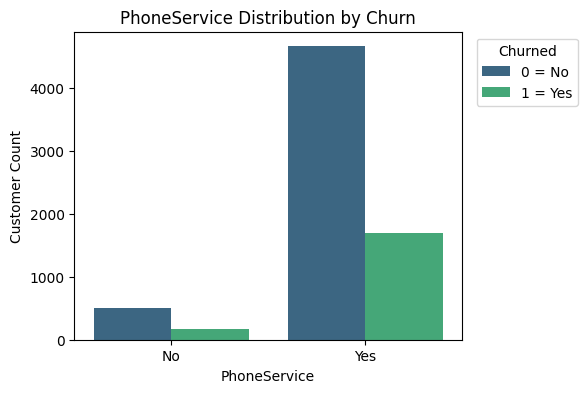

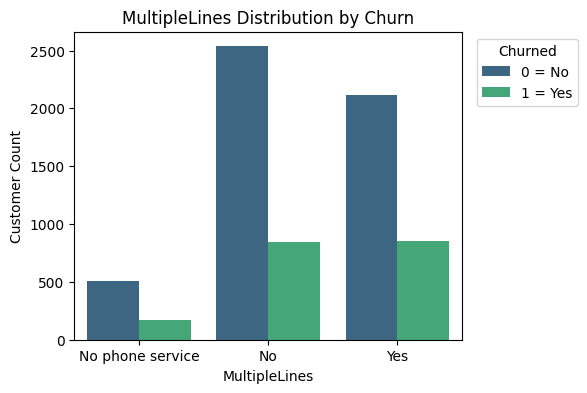

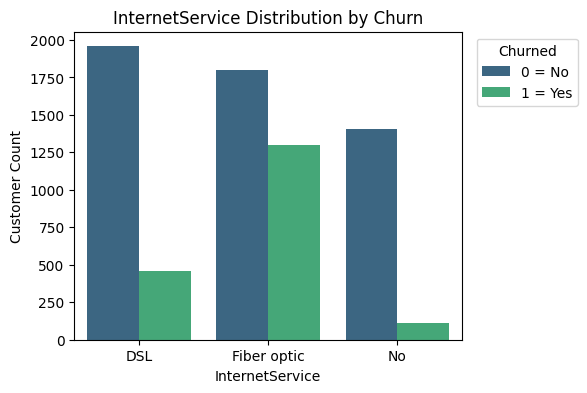

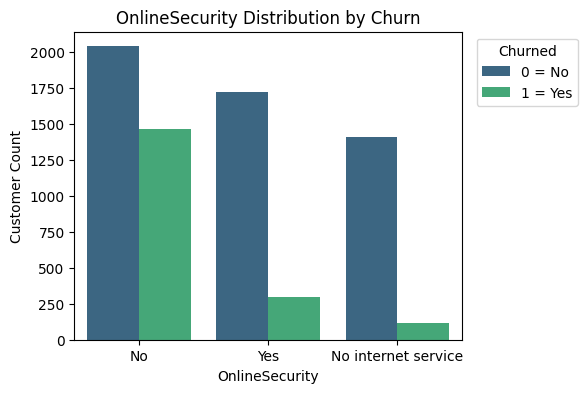

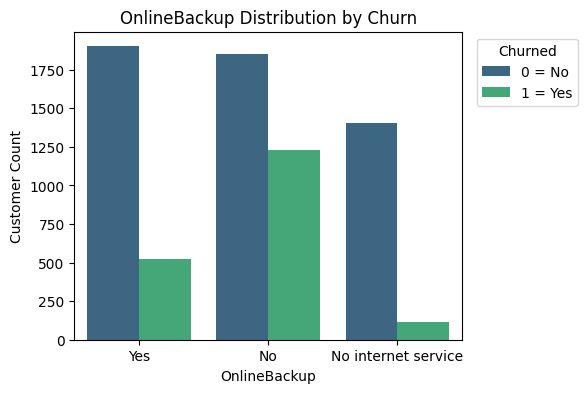

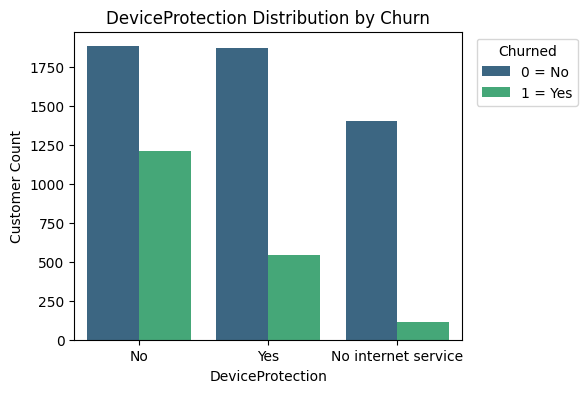

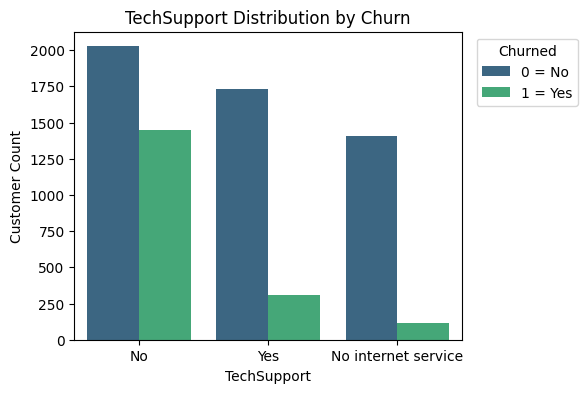

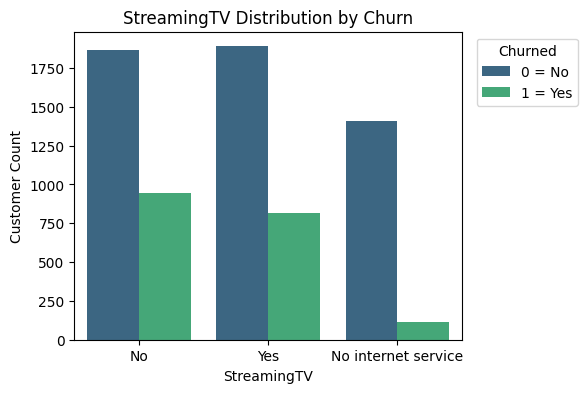

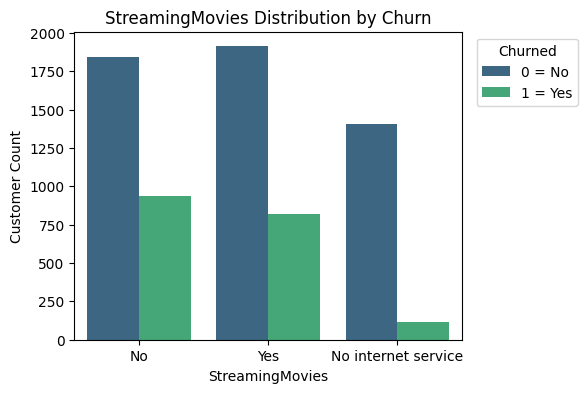

In [22]:
# Select service columns
services = [
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Plot the columns
for col in services:
    plt.figure(figsize=(5, 4))
    sns.countplot(
        data=telco_df,
        x=telco_df[col],
        hue=telco_df['Churn'],
        palette='viridis',
    )

    # Labels
    plt.title(f"{col} Distribution by Churn")
    plt.ylabel("Customer Count")
    plt.legend(
        title='Churned',
        labels=['0 = No', '1 = Yes'],
        loc='upper left',
        bbox_to_anchor=(1.02, 1)
    )

Findings from the above distributions:

Most of the customers subscribed for phone service and most of those that have phone service have not churned (above 4000) while approximately 1600 did. Of those that do not have phone services, the majority of them also have not churned, but not nearly as many as those that have phone service.

The majority of customers do not subscribed to multiple lines and this group also has the most non-churned customers (approximately 2500) followed by those that do have multiple lines where approximately 2200 customers have not churned. For each of these two groups (those who have multiple lines and those who don’t), the number of customers who churned are approximately 700.

Regarding internet service, the majority of customers who churned subscribed to fiber optic internet service (approximately 1250). Perhaps this type of internet service is more expensive. The minority of customers who churned had no internet service. The majority of customers who did not churn had DSL internet service (approximately 1900) followed by fiber optic internet service.

Most of the customers did not subscribe for online security and of these, approximately 1400 churned while 2100 did not. Perhaps these customers churned because they felt at higher risk of losing their information. Following this, approximately 1750 customers who did have internet service did not churn.

More or less the same can be said for those who do not subscribe for online backup. Most of the customers do not have online backup and of these approximately 1200 churned. Of those that do have backup, the majority did not churn.

Among those who do not subscribe to device protection, 1200 churned. For both those who do have device protection and those who don’t, more than 1750 customers did not churn.

For those who don’t subscribe to tech support, the majority (2000) did not churn. The majority of the customer who did churn, however, also belong to this group (approximately 1400).

For both movie and TV streaming services, the numbers are very similar. Of those who did not have either, approximately 900 churned and more than 1750 did not. Of those that had these services, approximately 750 churned and, again, more than 1750 did not.

Lastly, we will take a look at account information such as the type of contracts, whether they have paperless billing and the payment methods. (Tenure and charges were already covered.)

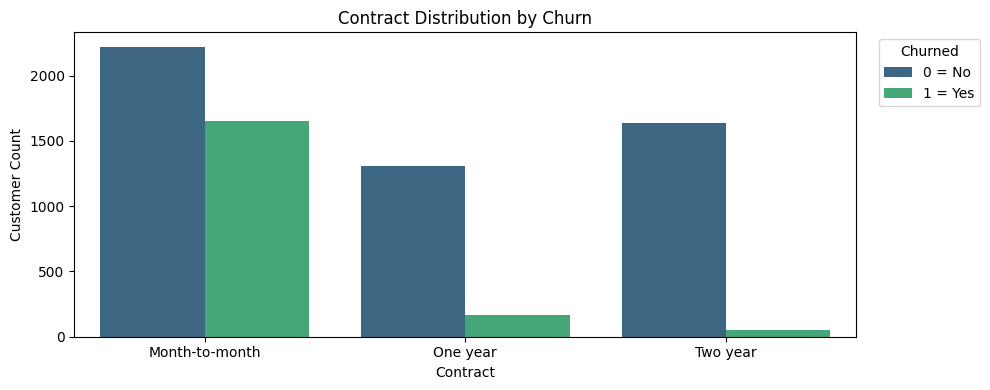

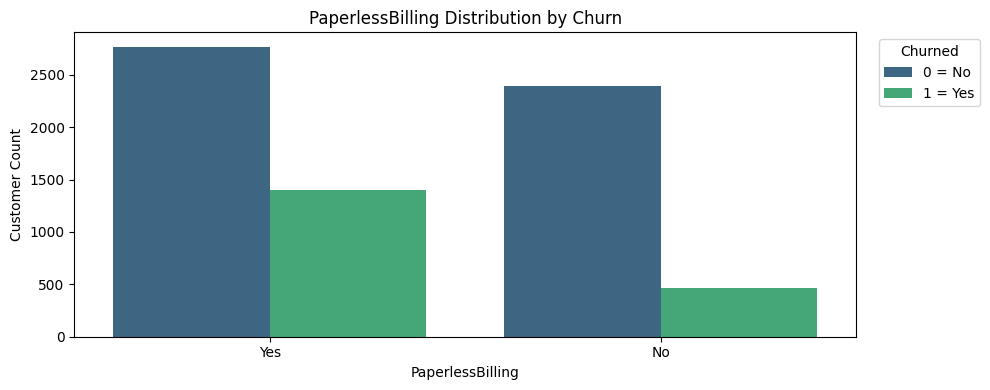

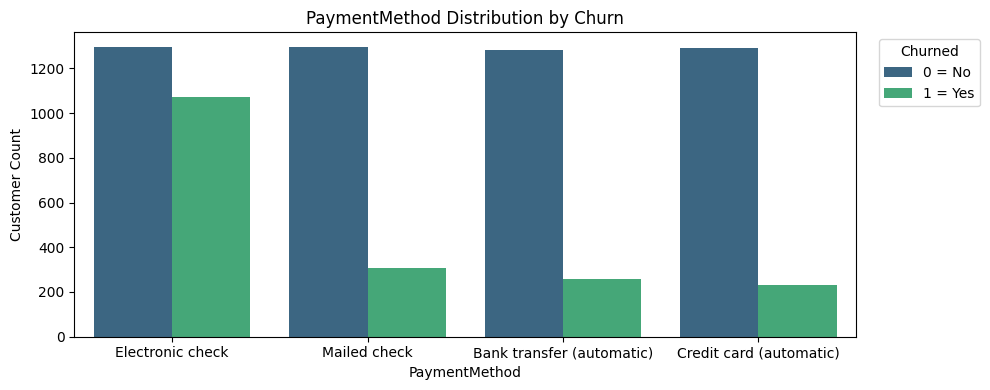

In [23]:
# Get account information columns
acc_info = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# Plot account information
for col in acc_info:
    plt.figure(figsize=(10, 4))
    sns.countplot(
        data=telco_df,
        x=telco_df[col],
        hue=telco_df['Churn'],
        palette='viridis',
    )

    # Labels
    plt.title(f"{col} Distribution by Churn")
    plt.ylabel("Customer Count")
    plt.legend(
        title='Churned',
        labels=['0 = No', '1 = Yes'],
        loc='upper left',
        bbox_to_anchor=(1.02, 1)
    )
    plt.tight_layout()

Findings from account information distributions:

The majority of customers had month-to-month contracts and most of the customers who churned also belong to this group (~ 1600). This group also had the most customers who did not churn (more than 2200) followed by those with a 2-year contract (1700). Of those with a 2-year contract, almost none of the customers churned indicating that the 2-year contract deals are very successful at customer retention while month-to-month contracts are to be targeted for retention techniques.

Those who have paperless billing are more like to churn (~ 1400) than those without (~ 500).

Customers who pay via electronic check are more likely to churn (~1100). The number of customers who do not churn are very similar for all for payment methods (about 1300 each). Like-wise, the number of customers who churned are nearly the same for the mailed check, bank transfer and credit card payment methods (slightly above 200).

Now that we have taken an in depth look at the dataset and trends, we can start preparing our machine learning models.

### Preparations for ML training

For the purpose of not losing our original dummie data, we will create a copy of the telecom_cust_dummies dataframe for the purpose of scaling.

In [24]:
# Create copy of dummie datafram
telecom_scaled = telecom_cust_dummies.copy().astype(float)

# Initialise scaler
scaler = MinMaxScaler()

# Fit scaler to new table
telecom_scaled.loc[:, :] = scaler.fit_transform(telecom_scaled)

Now we can take a look at the scaled dataframe.

In [25]:
# Confirm scaled dataframe
print("Scaled dummie dataframe:")
telecom_scaled.head()

Scaled dummie dataframe:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.000000,0.115423,0.001275,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.464789,0.385075,0.215867,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.014085,0.354229,0.010310,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.619718,0.239303,0.210241,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.014085,0.521891,0.015330,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


We will now move on to assigning our independant (X) and dependant (Y) variables and also confirm their shape. After that, we will split the data into our training and testing sets.

In [26]:
# Assign X and Y
X = telecom_scaled.drop('Churn', axis=1).values
Y = telecom_scaled['Churn'].values

# Ensure correct shapes
X = X.reshape(-1, X.shape[1])

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (7032, 30)
Shape of Y: (7032,)


In [27]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42
)

print(
    f"Training X shape: {X_train.shape}. Testing X shape: {X_test.shape}."
)
print(
    f"Training y shape: {y_train.shape}. Testing y shape: {y_test.shape}."
)

Training X shape: (5274, 30). Testing X shape: (1758, 30).
Training y shape: (5274,). Testing y shape: (1758,).


Now that we have successfully split our dataset into a training set for the purpose of training our models and a testing set to serve as unseen data for our models, we will start by creating and training our logistic regression model.

### Logistic regression model

The logistic regression model will be initiated and trained on our X and y training sets by fitting the training sets to the model. We will then make predictions on our “unseen” test dataset.

In [28]:
# Initialise logistic regression model
log_reg_model = LogisticRegression()

# Fit model to training data
log_reg_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [29]:
# Make predictions of test data
y_pred = log_reg_model.predict(X_test)

Now that the logistic regression model is trained and predictions can be made, we will assess this model based off of its accuracy score.

In [30]:
# Get Logistic model accuracy score
log_mod_acc = accuracy_score(y_test, y_pred)

print("Accuracy of logistic regression model:", log_mod_acc)

Accuracy of logistic regression model: 0.7912400455062572


This accuracy score indicates that out of all the predictions, the proportion of correct predictions is 79.12%. This is a good starting point for the model. We will also be looking at the precision and recall score for this model later on. For now, we will first move on to creating and training our random forest model.

### Random forest model

The random forest model will be created and then trained in a similar way as the logistic regression model in that we will train it using the X and y training sets by fitting these sets to the model. After that, we will make predictions of it using the test set.

In [31]:
# Initialise random forest model
rf_model = RandomForestClassifier(
    n_estimators=2000,
    oob_score=True,
    max_features="sqrt",
    max_leaf_nodes=50,
    bootstrap=True,
    random_state=42
)

For this random forest model, the following hyperparameters where tuned:

-	n_estimators: the number of trees is set to 2000.

-	oob_score: out-of-bag error estimation is enabled.

-	max_features: maximum number of features considered for splitting is set to ‘sqrt’ which considers a subset of features for splitting.

-	max_lead_nodes: maximum number of leaf nodes is set to 50 which constraints the complexity of the tree.

-	bootstrap: bootstrapping activated.


In [32]:
# Fit model to training data
rf_model.fit(X_train, y_train)

,n_estimators,2000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,50
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [33]:
# Make predictions on new test set
y_pred_rf = rf_model.predict(X_test)

Similarly to the logistic regression model, we will assess the random forest model based of its accuracy score.

In [34]:
# Get random forest model accuracy score
rf_mod_acc = accuracy_score(y_test, y_pred_rf)

print("Accuracy of random forest model:", rf_mod_acc)

Accuracy of random forest model: 0.7935153583617748


It appears that the random forest model has a slightly higher accuracy (79.35%) than the logistic regression model. This indicates that out of all the predictions, 79.35% were correctly predicted by the random forest model.

Let's take a look at the OOB score before moving on to our final model evaluations.

In [35]:
# Get OOB score
rf_oob = rf_model.oob_score_
print("Random forest model OOB score:", rf_oob)

# Get OOB error estimation
rf_oob_error = 1 - rf_oob
print("Random forest model OOB error estimation:", rf_oob_error)

Random forest model OOB score: 0.807356844899507
Random forest model OOB error estimation: 0.192643155100493


The OOB score indicates that 80.74% of the out-of-bag predictions were correct. The OOB error indicates that 19.26% were misclassified or wrongly predicted. These scores suggests that the model generalizes well.

To end off, we will look at the confusion matrix of each model as well as their precision and recall scores.

### Enhanced model evaluation

We will start with the confusion matrix of the logistic regression model.

Text(50.722222222222214, 0.5, 'Actual')

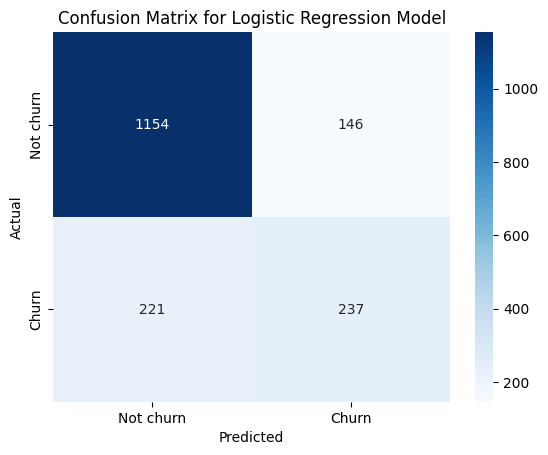

In [37]:
# Creat logistic regression model confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

labels = ["Not churn", "Churn"]

# Visualise logistic confusion matrix
plt.figure()
sns.heatmap(
    log_cm,
    annot=True,
    fmt='d',
    xticklabels=labels,
    yticklabels=labels,
    cmap="Blues"
)
plt.title("Confusion Matrix for Logistic Regression Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")

There were 1154 customers who did not churn and who were correctly predicted by the logistic regression model (true negatives). There were 146 customers who the model mistakenly predicted would churn but did not churn (false positives). Of the customers who did churn, 237 were correctly predicted (true positives). The model predicted that 221 did not churn, but these actually did churn (false negatives). Most of the non-churners were correctly predicted and this suggests that the model is better at predicting non-churners while it struggles to identify churners.

Now we will look at the confusion matrix of the random forest model.

Text(50.722222222222214, 0.5, 'Actual')

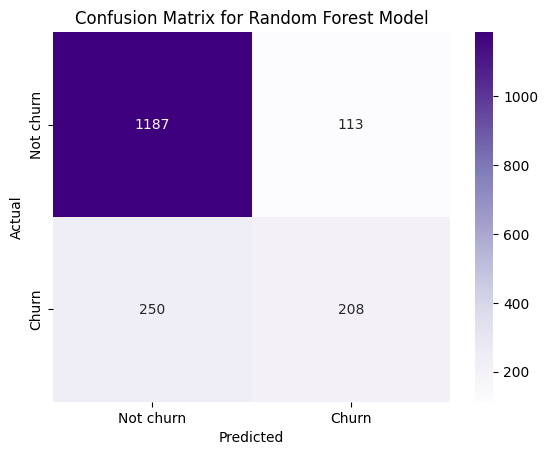

In [38]:
# Creat random forest model confusion matrix
rf_cm = confusion_matrix(y_test, y_pred_rf)

labels = ["Not churn", "Churn"]

# Visualise logistic confusion matrix
plt.figure()
sns.heatmap(
    rf_cm,
    annot=True,
    fmt='d',
    xticklabels=labels,
    yticklabels=labels,
    cmap="Purples"
)
plt.title("Confusion Matrix for Random Forest Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")

There were 1187 customers who did not churn and were correctly predicted (true negatives). There were 113 customers who the model predicted would churn but who actually did not (false positive). The model correctly predicted 208 of the customers to churn (true positives), but mistakenly predicted 250 to not churn but who actually did (false negative).

The random forest model has a relatively low false positive count in comparison with the logistic regression model. It is, therefore, slightly better at avoiding these false positives. It does, however, miss more actual churners than the logistic regression model since it has a higher false negative count.

To end off, we will evaluate the models based on their precision and recall scores.

In [39]:
# Calculate precision score for each model
log_mod_prec = precision_score(y_test, y_pred)
rf_mod_prec = precision_score(y_test, y_pred_rf)
print("Precision of logistic regression model:", log_mod_prec)
print("Precision of random forest model:", rf_mod_prec)

Precision of logistic regression model: 0.618798955613577
Precision of random forest model: 0.6479750778816199


The question to ask when it comes to precision is: of all the churners that the model predicted, who really did churn? A higher precision thus means there are fewer times churn is predicted when they actually don’t. In this case the random forest model has a higher precision score of 64.80% compared to the logistic regression model’s precision score of 61.88%. This could sound strange as we saw earlier that the model has a higher false negatives count, but precision does not factor in false negatives. Recall on the other hand does factor in false negatives. Does this mean that the recall score of the random forest model will be lower than that of the logistic regression model? Let’s take a look.

In [40]:
# Calculate recall score for each model
log_mod_rec = recall_score(y_test, y_pred)
rf_mod_rec = recall_score(y_test, y_pred_rf)
print("Recall of logistic regression model:", log_mod_rec)
print("Recall of random forest model:", rf_mod_rec)

Recall of logistic regression model: 0.517467248908297
Recall of random forest model: 0.45414847161572053


The question to ask when it comes to recall is: of all the actual churners, how many did the model catch? A higher recall thus means fewer misses. In this aspect, the logistic regression model has a higher recall of 51.75% compared to the random forest model’s 45.41%. It catches more churners than the random forest model. This was expected as we saw that the random forest model had more false negatives which is taken into account when it comes to recall.

### Conclusion

This dataset provided an insightful look into the features that affect customer churn.  We saw that features that are strongly correlated with churn are month-to-month contracts, no online security of tech support, fiber optic internet service, electronic check payment methods and no online backup or device protection. On the other hand, features that were negatively correlated with churn were tenure and two-year contracts.

We saw that most of the company’s customers are new subscribers followed by customers who have been with the company for more than 70 months.  Customers who have not churned have been with the company for longer. There are some outliers where customers have been with the company for long but then decided to churn. Most of the customers that churn does so during the first year.

Gender does not really play a role in predicting churn, but whether a person has a partner or dependents or not does make a difference. Customers who do not have partners or dependent are more likely to churn.

There is a positive relationship between total charges and monthly charges. As one increases, so does the other. There are customers with relatively high monthly charges but low total charges. Customers who have very high monthly charges mostly have very high total charges as well.

The majority of customers in this dataset are non-churners (~5000). The number of customers who churned are just below 2000. Churn is affected by many of the services the customers subscribe to. Most of them have phone services, fiber optic internet service, no online security, backup, device protection or tech support. Perhaps these services are too expensive and influences customers to churn. They also have month-to-month contract with paperless billing and electronic check. Customers could find this inconvenient.

We saw that the logistic regression model has a slightly lower accuracy score (79.12%) compared to the random forest model (79.35%) which means that the random forest model is correct more times than the logistic regression model. The accuracy score, however, is not always sufficient in evaluating a machine learning model and after looking at each model’s confusion matrix, precision and recall scores, we can conclude that when it comes to predicting customer churn (as is the goal of this task), the logistic regression model is better than the random forest model. This is because for churn, the recall score is more important as it means it catches more churners (51.80%) compared to the random forest model (45.41%). 

In conclusion, both models performed similar and well in terms of accuracy, but due to it’s higher recall, the logistic regression model is better suited. It can help the company take steps toward retention strategies to increase the number of non-churning customers.
